### some notes

0. Start the VNC from the launcher. The link should open in a different window.

1. Run the first cell below and wait for QT to be initialised before running the following cells. Run all cells will not work.

In [3]:
# Step 1: run the first cell and wait for QT to be initialised before running the following cells. 
# Use the novnc Desktop in the other window
import os
os.environ['DISPLAY'] = ':1.0'
# instantiate Qt GUI
%gui qt5

# Image

From the **Tutorial - brainglobe** https://docs.brainglobe.info/brainreg/tutorial
 , we have access to a "test_brain.zip"

In [4]:
# where to store the zip file
data_folder = "../data/"

# the url of the zip file
url = "https://gin.g-node.org/cellfinder/data/raw/master/brainreg/test_brain.zip"

theZipFile = os.path.basename(url)
theZipFile_nameNoExt= os.path.splitext(theZipFile)[0]
path_to_zip_file = data_folder+theZipFile 
directory_to_extract_to = data_folder 
final_folder = data_folder+theZipFile_nameNoExt+"/"

## Download the zip 
# import the requests library
import requests
 
# download the file contents in binary format
r = requests.get(url)
# open method to open a file on your system and write the contents
with open(path_to_zip_file, "wb") as code:
    code.write(r.content)
      
# Extract the zip file 
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref: 
    zip_ref.extractall(directory_to_extract_to)

# Now we can use Brainreg command line

In [5]:
brainreg_output_dir = "../brainreg_output/"

In [6]:
!brainreg $final_folder $brainreg_output_dir -v 50 50 50  --orientation psl --atlas allen_mouse_50um --sort-input-file

INFO:root:Starting logging
2021-07-08 07:35:44 AM INFO     2021-07-08 07:35:44 AM - INFO -  ]8;id=1625729744.0778568-742433;file:///opt/conda/lib/python3.8/site-packages/fancylog/fancylog.py\fancylog.py]8;;\:280
                                MainProcess fancylog.py:280 -                   
                                Starting logging                                
INFO:root:Not logging multiple processes
                       INFO     2021-07-08 07:35:44 AM - INFO -  ]8;id=1625729744.0807326-341071;file:///opt/conda/lib/python3.8/site-packages/fancylog/fancylog.py\fancylog.py]8;;\:281
                                MainProcess fancylog.py:281 -                   
                                Not logging multiple processes                  
INFO:root:Starting registration
                       INFO     2021-07-08 07:35:44 AM - INFO -       ]8;id=1625729744.082843-508155;file:///opt/conda/lib/python3.8/site-packages/brainreg/cli.py\cli.py]8;;\:197
               

DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2021-07-08 07:36:45 AM INFO     2021-07-08 07:36:45 AM -   ]8;id=1625729805.3170784-91799;file:///opt/conda/lib/python3.8/site-packages/nibabel/batteryrunners.py\batteryrunners.py]8;;\:274
                                INFO - MainProcess                              
                                batteryrunners.py:274 -                         
                                pixdim[0] (qfac) should be                      
                                1 (default) or -1; setting                      
                                qfac to 1                                       
DEBUG:root:Data type is: NifTI
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
                       INFO     2021-07-08 0

# We'll start using Napari from here

# Open the Image Of Interest (IOI) and the Atlas labels *fitted to the IOI* 
note : the IOI is resized to Atlas size

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import napari
import skimage.io

image_name = "downsampled.tiff"
image = skimage.io.imread(brainreg_output_dir+image_name)

atlas_name = "registered_atlas.tiff"
atlas = skimage.io.imread(brainreg_output_dir+atlas_name)

viewer = napari.view_image(data = image, colormap="gray")
viewer.add_labels(data=atlas , name="atlas")

/opt/conda/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Labels layer 'atlas' at 0x7f52a5bc60d0>

In [8]:
# here we make a mask of the region with a value 1021
region= atlas==1021
viewer.add_labels(data=region , name="Reg1021")

<Labels layer 'Reg1021' at 0x7f52f816d820>

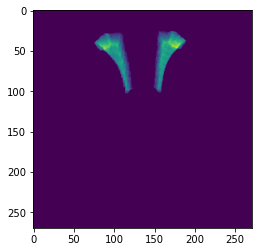

In [9]:
proj = np.average(region , axis = 1)
plt.imshow(proj);

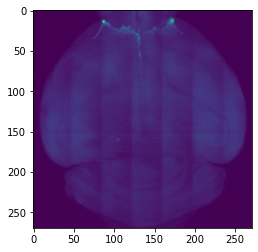

In [10]:
proj = np.average(image, axis = 1)
plt.imshow(proj);

# Open the Atlas and the IOI *fitted to the Atlas*

In [11]:
image_name = "downsampled_standard.tiff"

# the original atlas is stored in a different folder : home/jovyan/.brainglobe/name_of_atlas
# copy folder to /home/jovyan/work/brainreg/ , to be able to access data
# TODO : find a better way to do it
#atlas_folder = "../allen_mouse_25um_v1.2/"
atlas_folder = "/home/jovyan/.brainglobe/allen_mouse_50um_v1.2/"
atlas_name = "annotation.tiff"


image = skimage.io.imread(brainreg_output_dir+image_name)
atlas = skimage.io.imread(atlas_folder+atlas_name)

viewer = napari.view_image(data = image, colormap="green",name="brain")
viewer.add_labels(data=atlas, name="atlas")


/opt/conda/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Labels layer 'atlas' at 0x7f522c3e2a00>

# Match Value to Region name
We'll open the Atlas json file to get correspondance between gray value and Name of the Region

In [12]:
import json
atlasLabels_json = atlas_folder+"structures.json"

f = open(atlasLabels_json)

json_dict = json.load(f)

# Find value matching multiple Region(s)

In [13]:
regions_list = ['MO','VIS']

In [14]:
# using 'any' will result with some region that we don't want
region_acronym = [x['acronym'] for x in json_dict if any( x['acronym'] in r for r in regions_list)]
print(region_acronym)

['MO', 'VIS', 'V', 'VI']


In [15]:
# so we have to use 'set' ( https://docs.python.org/3/library/stdtypes.html?highlight=set#set ) 
# Better alternative might exist but you know : it works ! 

regions_acronym = [x['acronym'] for x in json_dict if len(set(regions_list).intersection(set([x['acronym']])))>0 ]
print(regions_acronym)

# here we need to set([ x['acronym'] ]) as there is only one acronym
regions_id = [x['id'] for x in json_dict if len(set(regions_list).intersection(set([x['acronym']])))>0 ]
print(regions_id)

# while here we can directly use set( x['structure_id_path'] )
regions_children = [x['id'] for x in json_dict if len(set(regions_id).intersection(set(x['structure_id_path'])))>0]
print(regions_children)

['MO', 'VIS']
[500, 669]
[500, 985, 320, 943, 648, 844, 882, 993, 656, 962, 767, 1021, 1085, 669, 402, 1074, 905, 1114, 233, 601, 649, 394, 281, 1066, 401, 433, 1046, 441, 409, 421, 973, 573, 613, 74, 121, 385, 593, 821, 721, 778, 33, 305, 425, 750, 269, 869, 902, 377, 393, 533, 805, 41, 501, 565, 257, 469, 312782574, 312782578, 312782582, 312782586, 312782590, 312782594, 312782598, 312782628, 312782632, 312782636, 312782640, 312782644, 312782648, 312782652]


#### Prepare a mask with all the defined regions

In [16]:
regions = np.zeros( image.shape, dtype=int)
for i in regions_children:
    region = atlas== i
    regions+=region

#### Use the mask on the image

In [17]:
mask = image * regions

#### Adds them to napari viewer

In [18]:
viewer.add_labels(data=regions , name="Regions")
viewer.add_image(data=mask,colormap="green").contrast_limits=(100, 500)

# Make and Save projection maps

In [ ]:
ouput_dir = "../output_data/"
os.mkdir(ouput_dir)

In [20]:
proj = np.average(image, axis = 1)
masked_proj = np.average(mask, axis = 1)

In [22]:
viewer_proj = napari.view_image(data = proj, name="proj")
viewer_proj.add_image(data = masked_proj, name="masked_proj")

/opt/conda/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'masked_proj' at 0x7f522d9acb80>

In [ ]:
skimage.io.imsave(ouput_dir+theZipFile_nameNoExt+"_proj.png", proj)
skimage.io.imsave(ouput_dir+theZipFile_nameNoExt+"_masked_proj.png", masked_proj)


# We're done, you can found your images in the output folder and download them!